In [1]:
from phi.torch.flow import*
import matplotlib.pyplot as plt 

In [2]:
# implement the scheme
def burgers_forward(u, dx, dt):
    u_new = np.zeros_like(u)
    N = len(u_new)
    coeff = .5 * dt / dx #constant

    #first point periodic domain
    if u[-1] + [1] < 0:
        u_new[0] = u[0] - coeff * (u[1] ** 2 - u[0] ** 2)
    else:
        u_new[0] = u[0] - coeff * (u[0] ** 2 - u[-1] ** 2)
    
    #last points periodic domain
    if u[-2] + u[0] < 0:
        u_new[-1] = u[-1] - coeff * (u[0] ** 2 - u[-1] ** 2)
    else:
        u_new[-1] = u[-1] - coeff * (u[-1] ** 2 - u[-2] ** 2)

    
    for i in range(1, N - 1):
        nei_avg = u[i - 1] + u[i + 1] # local avg of nei's
        if nei_avg < 0 :
            # print(f"u_i+1: {u[i + 1]}, u_i-1: {u[i - 1]} ")
            u_new[i] = u[i] - coeff * ( u[i + 1] ** 2 - u[i] ** 2)
        else:
            u_new[i] = u[i] - coeff * ( u[i] ** 2 - u[i - 1] ** 2)
    return u_new

In [3]:
# domain lenght 
Lx = 2 * PI
# discretisation points 
N = 32
# total number of steps
num_steps = 40
# domain params
dx = Lx / (N -1)
dt = dx 
sol = np.zeros(shape = (num_steps, N))

In [4]:
# locations
locs = np.linspace(start = 0, stop = 2 * PI, num = N)
# initial conditions
sol[0,:] = [math.sin(3 * loc) if loc < PI and loc > 0.5 * PI else 0 for loc in locs]

In [5]:
for i in range(1, num_steps):
    sol[i] = burgers_forward(sol[i - 1], dx ,dt)

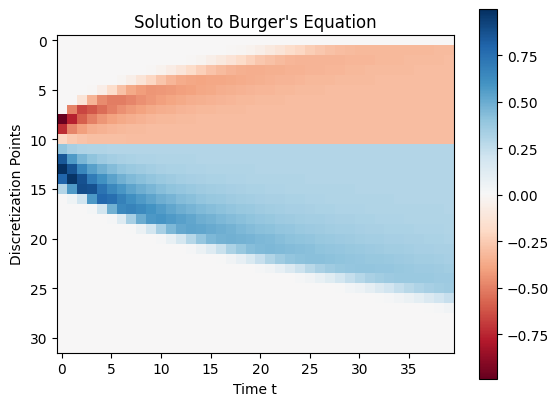

In [6]:
fig, ax = plt.subplots()
plt.title("Solution to Burger's Equation")
plt.xlabel("Time t")
plt.ylabel("Discretization Points")
plt.imshow(np.transpose(sol), cmap='RdBu')
plt.colorbar()
plt.show()


In [10]:
#we need ∂u_t/∂u_(t-1)
def burgers_backward(u, dx, dt):
    N = len(u)

    grad = np.zeros_like(u)
    coeff = .5 * dt / dx 

    if u[-1] + [1] < 0:
        # grad[0] = 1 + 2 * coeff * u[0]
        grad[0] = 1 + 2 * coeff * u[0]
    else:
        grad[0] = 1 - 2 * coeff * u[0] 
    
    if u[-2] + u[0] < 0:
        grad[-1] = 1 + 2 * coeff * u[-1]
    else:
        grad[-1] = 1 - 2 * coeff * u[-1]


    for i in range(1, N-1):
        nei_avg = u[i - 1] + u[i + 1]
        if nei_avg < 0:
            # grad[i] = 1 - 2 * coeff * ( u[i + 1] - u[i] )
            grad[i] = 1 + 2 * coeff *  u[i]
  
        else:
            grad[i] = 1 - 2 * coeff * u[i]

    return grad



In [11]:
def loss_func(prediction, target):
    return np.square(target - prediction).mean()
def grad_loss_func(preddiction, target):
    return 2 * (preddiction - target) / len(preddiction)

In [12]:
def burgers_simulate(initial_state, dx, dt, num_steps):
    internal_states = list()
    state = initial_state
    for i in range(num_steps - 1):
        internal_states.append(state)
        state = burgers_forward(state, dx, dt)
    return state, internal_states 

In [13]:
def backward_iter(internal_states, dx, dt):
    num_steps, N = np.shape(internal_states)
    grad_total = np.ones(N)
    for i in reversed(range(num_steps)):
        u = internal_states[i]
        grad = burgers_backward(u,dx, dt) # ∂u_t / ∂u_{t - 1}
        grad_total *= grad
    return grad_total

In [14]:
Lx = 2 * PI
# discretisation points 
N = 32
# total number of steps
num_steps = 40
# domain params
dx = Lx / (N -1)
dt = .1 * dx 

num_steps = 15

In [15]:
time_15 = np.load("burgers_target_state.npy") # target 
time_0 = np.sin(locs) # initial guess for t_0
init_vals = time_0

In [17]:
def backpropagation(u0, target, dx, dt, lr ,num_iters):
    for iter in range(num_iters):
        u_15, internal_states = burgers_simulate(u0, dx, dt, num_steps = 15)

        loss = loss_func(u_15, target)
        if iter % 100 == 0:
            print(f"Iteration: {iter}, Loss: {loss}")
        if iter == 250:
            lr *= .1
        grad_output = grad_loss_func(u_15, target)
        grad_internal_states = backward_iter(internal_states, dx, dt)
        grad = np.multiply(grad_internal_states, grad_output)
        u0 -= lr * grad
    return u0

In [18]:
lr = .1
num_iters = 2000
u0_optimized = backpropagation(time_0, time_15, dx, dt, lr, num_iters)

Iteration: 0, Loss: 2.192313929819946
Iteration: 100, Loss: 1.400337888317142
Iteration: 200, Loss: 0.7291237857538302
Iteration: 300, Loss: 0.4267813018077336
Iteration: 400, Loss: 0.36314646887201907
Iteration: 500, Loss: 0.3354598035218966
Iteration: 600, Loss: 0.3178775908349867
Iteration: 700, Loss: 0.30568081672955116
Iteration: 800, Loss: 0.2958684410499573
Iteration: 900, Loss: 0.28710665504696165
Iteration: 1000, Loss: 0.2792435418767617
Iteration: 1100, Loss: 0.2718761762414618
Iteration: 1200, Loss: 0.2649215903939316
Iteration: 1300, Loss: 0.2575633725994343
Iteration: 1400, Loss: 0.25120478445025596
Iteration: 1500, Loss: 0.24447731571628642
Iteration: 1600, Loss: 0.2386297288263421
Iteration: 1700, Loss: 0.23301389746851658
Iteration: 1800, Loss: 0.2270060845091152
Iteration: 1900, Loss: 0.22181064438716408


In [19]:
time_15_optimized = burgers_forward(u0_optimized, dx, dt)

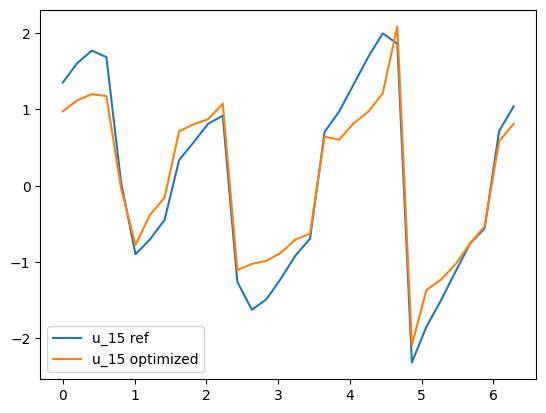

In [22]:
plt.plot(locs, time_15, label = "u_15 ref")
plt.plot(locs, time_15_optimized, label = "u_15 optimized")
plt.legend()